Ideas:

- Do the "spline" or interpolation method and then just pick the closest point in the workspace to send to the inverse kinematics funtion
- The "workspace" could be just a hardcoded circle in matplotlib since l1 and l2 and concrete
- We could do the iterative inverse kinematics which I kinda like, the other option would be calculating the Jacobian which we could honestly do by hand and then hardcode it
- We can simplify the animation by just calculating two points, the middle joint and the end effector and then drawing lines between them and then animating the drawing of them with fine enough adjustments so it's smooth
- I have no idea how we'll click to make the points, should start with hardcoding points for the interpolation
- I forsee us needing to make sure the inverse kinematics always chooses the "righty solution" and doesn't randomly flip between the righty and lefty solutions while it's moving
- If we set the length of the arrays of the final curve to say 1000 then we can have a consistently timed animation regardless of points chosen, the robot will just move slower or faster depending on how much it needs to travel
- We should probably precalculate the inverse kinematics before the animation instead of doing the inverse kinematics point by point during the animation

Functions needed:

- Forward kinematics
  - Input: two theta values
  - Output: two positions, one for the middle joint and one for the end effector
- Inverse kinematics
  - Input: position of end effector, make it required that the point sent in is confirmed to be in the workspace of the robot
  - Output: two theta values to get there
- Valid workspace position checker
  - Input: a desired end effector position
  - Output: the closest position that is within the workspace, if the desired position is in the workspace then no change to the position happens
- Interpolator
  - Input: 5 (x,y) coordinates
  - Output: an array of an interpolated curved line that goes through all 5 points with fine enough resolution that the points look like a smooth line
- XY coordinate clicker method
  - Something that can take the user's mouse input and outputs 5 points that are clicked on a x-y coordinate graph
- Drawing methods
  - Things we need to draw: the circles representing the workspace, the points clicked, the interpolated curve, the allowed positions curve, the actual robot arms
- An animator function
  - Will step through every point on the allowed positions curve and redraw everything over a set period of time


Global variables that need set up:
- Current positions of middle joint and end effector
- The lengths of the two arms
- Array of 5 desired positions
- Array of interpolated desired positions
- Array of allowed positions
- Array of final middle joint and end effector positions to animate through


In [119]:
import numpy as np
import math
import matplotlib.pyplot as plt
#matplotlib widget
%matplotlib widget

In [120]:
middle_path = np.array((float,float))    # will hold the (x,y) coordinates of the middle joint
ee_path = np.array((float,float))        # will hold the (x,y) coordinates of the end effector
L1 = 1.0                    # length of first link
L2 = 0.5                    # length of second link
middle_path_desired = np.array((float,float))    # will hold the (x,y) coordinates of the desired middle joint path
ee_path_desired = np.array((float,float))        # will hold the (x,y) coordinates of the desired end effector path

# placeholder desired points values
x = np.array([0.0, 1.0, 0.0, -0.3, -0.5])
y = np.array([0.5, 0.5, -1.4, 0.7, -0.5])

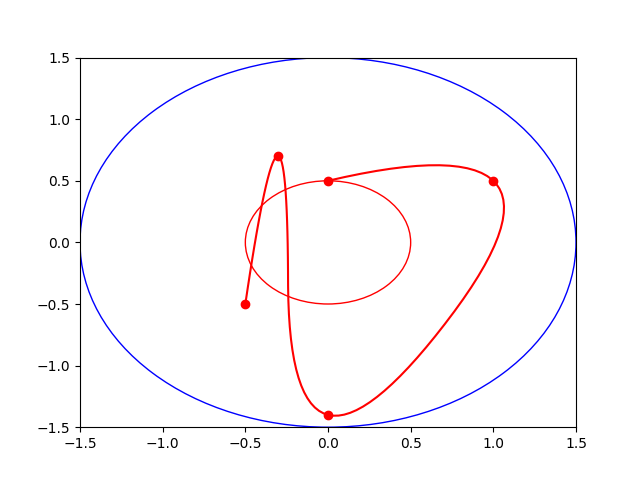

In [121]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

L1 = 1.0
L2 = 0.5

minRadius = L1 - L2
maxRadius = L1 + L2

# Source: https://stackoverflow.com/questions/9215658/plot-a-circle-with-matplotlib-pyplot
fig , ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

maxCircle = plt.Circle((0, 0), maxRadius, color='blue', fill=False)
minCircle = plt.Circle((0, 0), minRadius, color='red', fill=False)

ax.add_patch(maxCircle)
ax.add_patch(minCircle)

# source: ginput documentation (https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.ginput.html)
# points = plt.ginput(n=-1)


# pts = np.array(points)
# x = pts[:, 0]
# y = pts[:, 1]

tck, u = splprep([x, y], s=0, k=2)
u_new = np.linspace(u.min(), u.max(), 100)
ee_path_desired = splev(u_new, tck)

ax.plot(x, y, 'ro')
ax.plot(ee_path_desired[0], ee_path_desired[1], 'r-')
plt.show()

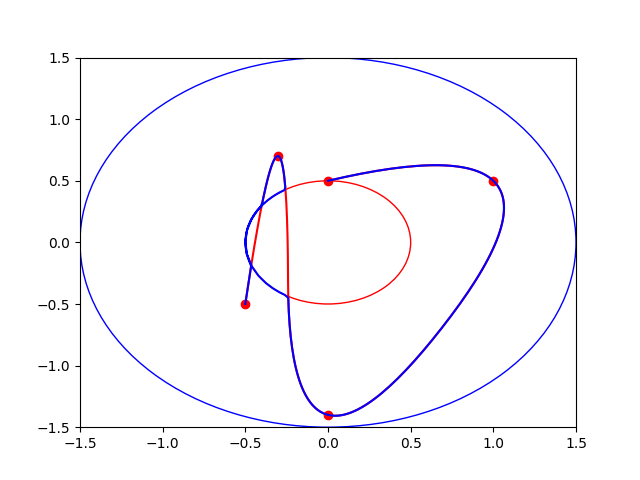

In [122]:
tck, u = splprep([x, y], s=0, k=2)
u_new = np.linspace(u.min(), u.max(), 200)
ee_path_desired = splev(u_new, tck)

allowed_x, allowed_y = [], []

for i in range(len(ee_path_desired[0])):
    desired_x = ee_path_desired[0][i]
    desired_y = ee_path_desired[1][i]
    theta = math.atan2(ee_path_desired[1][i], ee_path_desired[0][i])
    if (math.sqrt(math.pow(ee_path_desired[0][i],2)+math.pow(ee_path_desired[1][i],2)) < minRadius):
        allowed_x.append(math.cos(theta)*minRadius)
        allowed_y.append(math.sin(theta)*minRadius)
    elif (math.sqrt(math.pow(ee_path_desired[0][i],2)+math.pow(ee_path_desired[1][i],2)) > maxRadius):
        allowed_x.append(math.cos(theta)*minRadius)
        allowed_y.append(math.sin(theta)*minRadius)
    else:
        allowed_x.append(desired_x)
        allowed_y.append(desired_y)

fig , ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

maxCircle = plt.Circle((0, 0), maxRadius, color='blue', fill=False)
minCircle = plt.Circle((0, 0), minRadius, color='red', fill=False)
ax.add_patch(maxCircle)
ax.add_patch(minCircle)


ee_path = np.asarray(ee_path)
ax.plot(x, y, 'ro')
ax.plot(ee_path_desired[0], ee_path_desired[1], 'r-')
ax.plot(allowed_x, allowed_y, 'b-')
plt.show()


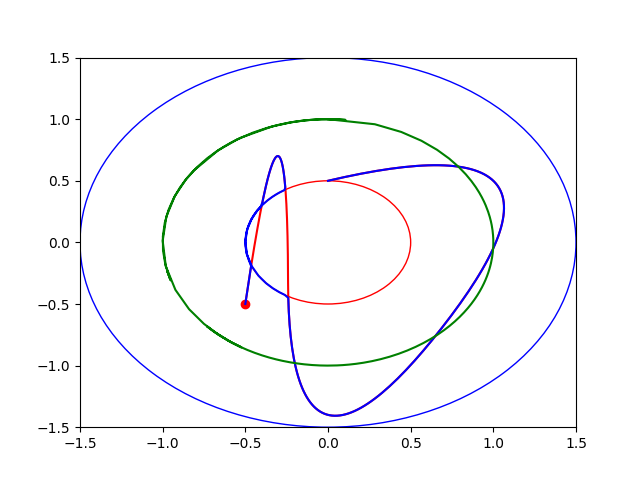

In [123]:
# Reference: Lecture 11 slides and https://www.mathworks.com/help/fuzzy/modeling-inverse-kinematics-in-a-robotic-arm.html

def inverse_kinematics(x, y, L1, L2):
    r2 = x*x + y*y
    c2 = (r2 - L1*L1 - L2*L2) / (2.0*L1*L2)
    s2 = math.sqrt(1.0 - c2*c2)  # elbow-up only
    theta2 = math.atan2(s2, c2)
    theta1 = math.atan2(y, x) - math.atan2(L2*s2, L1 + L2*c2)
    # print(theta1)
    return theta1, theta2

theta1 = []
theta2 = []

for x, y in zip(allowed_x, allowed_y):
  th1, th2 = inverse_kinematics(x, y, L1, L2)
  theta1.append(th1)
  theta2.append(th2)

middle_x = []
middle_y = []

for theta in theta1:
  middle_x.append(math.cos(theta)*L1)
  middle_y.append(math.sin(theta)*L1)

ee_x = allowed_x
ee_y = allowed_y

fig , ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

maxCircle = plt.Circle((0, 0), maxRadius, color='blue', fill=False)
minCircle = plt.Circle((0, 0), minRadius, color='red', fill=False)
ax.add_patch(maxCircle)
ax.add_patch(minCircle)

ax.plot(x, y, 'ro')
ax.plot(ee_path_desired[0], ee_path_desired[1], 'r-')
ax.plot(ee_x, ee_y, 'b-')
ax.plot(middle_x, middle_y, 'g-')
plt.show()

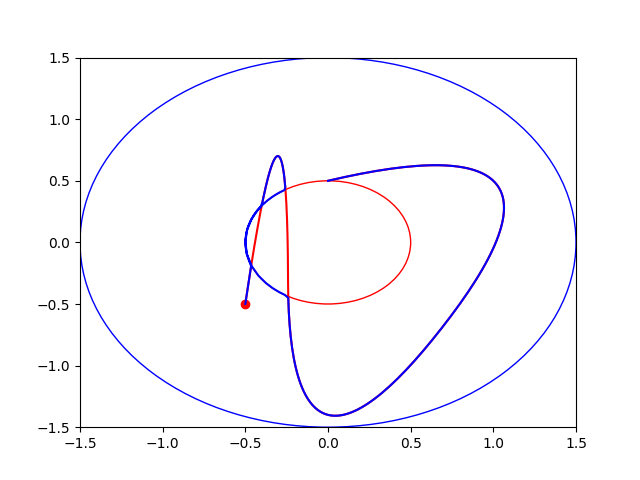

In [124]:
# Reference: https://matplotlib.org/stable/users/explain/animations/animations.html

import matplotlib.animation as animation

fig , ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

maxCircle = plt.Circle((0, 0), maxRadius, color='blue', fill=False)
minCircle = plt.Circle((0, 0), minRadius, color='red', fill=False)
ax.add_patch(maxCircle)
ax.add_patch(minCircle)

ax.plot(x, y, 'ro')
ax.plot(ee_path_desired[0], ee_path_desired[1], 'r-')
ax.plot(ee_x, ee_y, 'b-')
(l1_line,) = ax.plot([], [], lw=3)
(l2_line,) = ax.plot([], [], lw=3)

def update(frame):
    # for each frame, update the data stored on each artist.
    x_base = 0.0
    y_base = 0.0

    x_middle = middle_x[frame]
    y_middle = middle_y[frame]

    x_ee = ee_x[frame]
    y_ee = ee_y[frame]

    # update the scatter plot:
    l1_line.set_data([x_base, x_middle], [y_base, y_middle])
    l2_line.set_data([x_middle, x_ee], [y_middle, y_ee])

    return l1_line, l2_line


ani = animation.FuncAnimation(fig=fig, func=update, frames=len(ee_y), interval=30)
plt.show()
ani.save("test.mp4")